# Domain 1: Crowdsourcing to Support Education Needs

# Predicting projects that are unlikely to be funded without expert assistance to prioritize resources for DonorsChoose

## This notebook contains Classification Task Models for predicting T/F- whether or not a project will be funded at the time of its posting date

### Arthur Spirou (aspirou), Akin Joseph (ababujos), & Nikki Chen (yiqichen)
Machine Learning Foundations with Python

Due: May 3, 2025

### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.display import display
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [3]:
# Example if using Google Colab
#from google.colab import drive

In [5]:
#drive.mount('/content/drive')

In [7]:
# Colab read example
#df = pd.read_csv('/content/drive/My Drive/ML Project/TIDY.csv')

# First, split, clean, and process data prior to proceeding to Grid Search, Cross-Validation, and Model Testing

### Read in the Data

In [3]:
data = pd.read_csv('TIDY.csv')

In [5]:
# Make a copy and save the original version of the data for sanity
df = data.copy()

In [7]:
# Uncomment the line below to see the full list of columns
print(df.columns.tolist())

['projectid', 'teacher_acctid_x', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'date_posted', 'is_exciting', 'at_least_1_teacher_referred_donor', 'fully_funded', 'at_least_1_green_donation', 'great_chat', 'three_or_more_non_teacher_referred_donors', 'one_non_teacher_referred_donor_giving_100_plus', 'donation_from_thoughtful_donor', 'g

# Remove the year 2014 as we do not have labels for these projects, then select desired features to include
### Features from TIDY may be added or removed as desired, taking care to avoid including outcome info other than for purposes of a label
### Note that this block defines columns which necessarily include projectid + date and others for now which will be dropped later as they won't be features in our models

In [10]:
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Filter out any rows posted in 2014 or later
df = df[df['date_posted'] < pd.Timestamp('2014-01-01')]

# Define columns to keep
selected_columns = [
    'school_state', 
    'school_charter',
    'school_magnet',
    'school_kipp',
    'school_charter_ready_promise',
    'school_nlns',
    'teacher_teach_for_america',
    'teacher_ny_teaching_fellow',
    'total_price_including_optional_support',
    'primary_focus_subject',
    'resource_type',
    'poverty_level',
    'grade_level',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match',
    'fully_funded',           # label (gets remapped below so that fully_funded = 1 means a project was not funded and fully_funded = 0 means it was funded)
    'projectid',              # keep for row ID reference (not ML input) ***Rows are defined by unique projectid + date_posted combinations***
    'date_posted',            # keep for date-based split (not ML input)
    'sp500_avg_30d',
    'sp500_std_30d',
    'essay_length',
    'total_item_quantity',
    'num_items',
    'total_item_cost',
    'need_statement_length',
    'teacher_prefix',
    'state_gdp',
    'month_of_year',
    'day_of_week',
    'school_metro'
]

df_filtered = df[selected_columns]

print(f"Filtered data shape: {df_filtered.shape}")
df_filtered.head()

Filtered data shape: (619326, 30)


,school_state,school_charter,school_magnet,school_kipp,school_charter_ready_promise,school_nlns,teacher_teach_for_america,teacher_ny_teaching_fellow,total_price_including_optional_support,primary_focus_subject,...,essay_length,total_item_quantity,num_items,total_item_cost,need_statement_length,teacher_prefix,state_gdp,month_of_year,day_of_week,school_metro
0,NY,f,t,f,f,f,f,f,279.27,Other,...,1254.0,0.0,0.0,0.0,75.0,Mr.,876285.2,9,4,urban
1,NY,f,f,f,f,f,f,f,152.44,Literacy,...,2272.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,4,NaN
2,NY,f,t,f,f,f,f,f,152.44,Early Development,...,1239.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,0,urban
3,NY,f,f,f,f,f,f,f,998.78,Other,...,1825.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,1,urban
4,NY,f,f,f,f,f,f,f,1376.83,Economics,...,2271.0,0.0,0.0,0.0,263.0,Mr.,876285.2,9,1,urban


### Missing Values/Outliers Check, Print outlier summary but don't treat until after train/test split
Note: Some previous cleaning has already been done on this data but not on all possible features

In [13]:
# Columns to check for outliers
numeric_cols = [
    'total_price_including_optional_support',
    'sp500_avg_30d',
    'sp500_std_30d',
    'essay_length',
    'total_item_quantity',
    'num_items',
    'total_item_cost',
    'need_statement_length',
    'state_gdp'
]

# NaN summary
nan_summary = df_filtered.isna().sum().to_frame(name='missing_count')
nan_summary['missing_pct'] = (nan_summary['missing_count'] / len(df_filtered)) * 100

# Outlier summary for the two price columns
outlier_summary = pd.DataFrame(columns=['lower_bound', 'upper_bound', 'outlier_count', 'outlier_pct'])

for col in numeric_cols:
    lower = df_filtered[col].quantile(0.01)
    upper = df_filtered[col].quantile(0.99)
    outlier_mask = (df_filtered[col] < lower) | (df_filtered[col] > upper)
    outlier_count = outlier_mask.sum()
    outlier_pct = outlier_count / len(df_filtered) * 100

    outlier_summary.loc[col] = [lower, upper, outlier_count, outlier_pct]

# Combine both summaries
summary_report = nan_summary.copy()
summary_report[['lower_bound', 'upper_bound', 'outlier_count', 'outlier_pct']] = outlier_summary

# Show full report
summary_report.fillna('', inplace=True)
summary_report

,missing_count,missing_pct,lower_bound,upper_bound,outlier_count,outlier_pct
school_state,0,0.000000,,,,
school_charter,0,0.000000,,,,
school_magnet,0,0.000000,,,,
school_kipp,0,0.000000,,,,
school_charter_ready_promise,0,0.000000,,,,
school_nlns,0,0.000000,,,,
teacher_teach_for_america,0,0.000000,,,,
teacher_ny_teaching_fellow,0,0.000000,,,,
total_price_including_optional_support,0,0.000000,147.56,2822.635,12344.0,1.993134
primary_focus_subject,36,0.005813,,,,


### Convert t/f values to binary, and rename/remap the label from fully_funded to not_fully_funded

In [16]:
df_cleaned = df_filtered.copy()
# Convert t/f → 1/0 for standard binary columns
binary_cols = [
    'school_charter',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match',
    'school_magnet',
    'school_kipp',
    'school_charter_ready_promise',
    'school_nlns',
    'teacher_teach_for_america',
    'teacher_ny_teaching_fellow'
]

for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'t': 1, 'f': 0})

# Convert t/f → 0/1 for the label (fully_funded: 't' means funded → now label 0)
df_cleaned['not_fully_funded'] = df_cleaned['fully_funded'].map({'t': 0, 'f': 1})
df_cleaned.drop(columns='fully_funded', inplace=True)

#df_cleaned.head()

In [18]:
# Reprint full missing values summary for peace of mind
print("Any missing values left?", df_cleaned.isna().any().any())
print("Total missing values:", df_cleaned.isna().sum().sum())

Any missing values left? True
Total missing values: 78027


In [20]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619326 entries, 0 to 619325
Data columns (total 30 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   school_state                            619326 non-null  object        
 1   school_charter                          619326 non-null  int64         
 2   school_magnet                           619326 non-null  int64         
 3   school_kipp                             619326 non-null  int64         
 4   school_charter_ready_promise            619326 non-null  int64         
 5   school_nlns                             619326 non-null  int64         
 6   teacher_teach_for_america               619326 non-null  int64         
 7   teacher_ny_teaching_fellow              619326 non-null  int64         
 8   total_price_including_optional_support  619326 non-null  float64       
 9   primary_focus_subject                   61

In [22]:
df_merged = df_cleaned.copy()

In [24]:
# Sanity check on the start and end dates of the data prior to proceeding with train/test splits
print(df_merged['date_posted'].min(), '\n', df_merged['date_posted'].max())

2002-09-13 00:00:00 
 2013-12-31 00:00:00


In [26]:
# transform the binary columns to bool prior to encoding because they are currently ints
for col in binary_cols:
    df_merged[col] = df_merged[col].astype('bool')

In [28]:
# transform day of week and month of year int categories into objects for one-hot encoding
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

df_merged['day_of_week'] = df_merged['day_of_week'].map(dict(zip(range(7), days))).astype('category')
df_merged['month_of_year'] = df_merged['month_of_year'].map(dict(zip(range(1, 13), months))).astype('category')

In [30]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619326 entries, 0 to 619325
Data columns (total 30 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   school_state                            619326 non-null  object        
 1   school_charter                          619326 non-null  bool          
 2   school_magnet                           619326 non-null  bool          
 3   school_kipp                             619326 non-null  bool          
 4   school_charter_ready_promise            619326 non-null  bool          
 5   school_nlns                             619326 non-null  bool          
 6   teacher_teach_for_america               619326 non-null  bool          
 7   teacher_ny_teaching_fellow              619326 non-null  bool          
 8   total_price_including_optional_support  619326 non-null  float64       
 9   primary_focus_subject                   61

# Now, conduct 80%-20% Time series test/train split
### Sort the data by date and split at the 80% index, then select the feature and target columns

### Create Masks and Conduct earliest 80%/latest 20% Train/Test Split based on data sorted by project posting date

In [34]:
# Sort by time
df_sorted = df_merged.sort_values('date_posted')

# Get 80% split index
split_index = int(0.8 * len(df_sorted))

# Get the cutoff date at that index
cutoff_date = df_sorted.iloc[split_index]['date_posted']

# Create masks using cutoff_date
train_mask = df_merged['date_posted'] < cutoff_date
test_mask = ~train_mask

print("Cutoff date for 80/20 split:", cutoff_date)

# Set up feature and target columns
df_model = df_merged.copy()
target_col = 'not_fully_funded'

columns_to_drop = ['projectid', 'date_posted', 'not_fully_funded', 'year_posted']
feature_cols = [col for col in df_model.columns if col not in columns_to_drop]

# Apply masks to split data
X_train = df_model.loc[train_mask, feature_cols]
y_train = df_model.loc[train_mask, target_col]

X_test = df_model.loc[test_mask, feature_cols]
y_test = df_model.loc[test_mask, target_col]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target distribution in train:\n{y_train.value_counts()}")
print(f"Target ratio in train:\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution in test:\n{y_test.value_counts()}")
print(f"Target ratio in test:\n{y_test.value_counts(normalize=True)}")

Cutoff date for 80/20 split: 2013-01-28 00:00:00
Train shape: (495255, 27), Test shape: (124071, 27)
Target distribution in train:
not_fully_funded
0    343322
1    151933
Name: count, dtype: int64
Target ratio in train:
not_fully_funded
0    0.693223
1    0.306777
Name: proportion, dtype: float64
Target distribution in test:
not_fully_funded
0    87361
1    36710
Name: count, dtype: int64
Target ratio in test:
not_fully_funded
0    0.704121
1    0.295879
Name: proportion, dtype: float64


In [36]:
# Run following blocks of info prints for another sanity check summary after doing the train/test splits
#print('X_train info:', X_train.info())

In [38]:
#print('X_test info:', X_test.info())

In [40]:
#print('y_train info:', y_train.info())

In [42]:
#print('y_test info:', y_test.info())

# Now, treat outliers on the train set only (to avoid data leakage or spoiling our real-world test set)
### We decided to cap most numeric outliers to prevent overfitting but preserve as much natural order as possible

In [45]:
# cap outliers using the IQR method
def handle_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        if col == 'state_gdp':
            continue # don't cap outliers for state_gdp
        if df_clean[col].dtype in ['int64', 'float64']:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
            print(f"Column {col}: {outliers} outliers capped")

            df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
    return df_clean

# Apply the capping to numeric columns
X_train = handle_outliers(X_train, numeric_cols)

Column total_price_including_optional_support: 22074 outliers capped
Column sp500_avg_30d: 0 outliers capped
Column sp500_std_30d: 35455 outliers capped
Column essay_length: 3589 outliers capped
Column total_item_quantity: 39370 outliers capped
Column num_items: 46399 outliers capped
Column total_item_cost: 19097 outliers capped
Column need_statement_length: 30751 outliers capped


# The following two code blocks contain variance and correlation column filters to remove those that are not helpful
### The filter is applied to the train set only and then if columns are to be dropped the same mapping applied to the train set is carried out on the test set

### Conduct variance thresholding to drop unhelpful columns

Drops columns with little variance from train set (means they have little predictive power and just clutter the model)

In [49]:
# Recompute numeric columns after outlier handling
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Apply VarianceThreshold to numeric features only (fit only on train!)
var_thresh = VarianceThreshold(threshold=0.005)
X_train_numeric = var_thresh.fit_transform(X_train[numeric_cols])
X_test_numeric = var_thresh.transform(X_test[numeric_cols])

# Get columns to keep and drop
kept_numeric_cols = X_train[numeric_cols].columns[var_thresh.get_support()].tolist()
dropped_numeric_cols = list(set(numeric_cols) - set(kept_numeric_cols))

print(f"Removed {len(dropped_numeric_cols)} low-variance numeric features:")
for col in sorted(dropped_numeric_cols):
    print(f" - {col}")

# Rebuild X_train and X_test: high-variance numeric features + all other columns
X_train = pd.concat([
    pd.DataFrame(X_train_numeric, columns=kept_numeric_cols, index=X_train.index),
    X_train.drop(columns=numeric_cols)
], axis=1)

X_test = pd.concat([
    pd.DataFrame(X_test_numeric, columns=kept_numeric_cols, index=X_test.index),
    X_test.drop(columns=numeric_cols)
], axis=1)

Removed 0 low-variance numeric features:


### Correlation Filter to compliment the above variance filter

Finds pairs of features which are highly correlated to each other and drops one from the pair- this helps to reduce overfitting

In [52]:
# Only look at numeric features again (post-variance filter)
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = X_train[numeric_cols].corr().abs()

# Create upper triangle mask
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set correlation threshold
corr_threshold = 0.9

# Find columns with high correlation to others
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]

# Drop from both X_train and X_test
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

print(f"\nRemoved {len(to_drop)} highly correlated numeric features (threshold > {corr_threshold}):")
for col in sorted(to_drop):
    print(f" - {col}")


Removed 1 highly correlated numeric features (threshold > 0.9):
 - total_item_cost


# Create Column Transformer for automated feature encoding
### numeric features get scaled and imputed with median while categorical features get one-hot encoded and the value 'uknown' imputed
### ordinal features also get imputed with 'unknown' to preserve data integrity, and each of these has its specific ordering defined

In [55]:
# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
bool_features = X_train.select_dtypes(include=['bool']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features += bool_features  # treat bools as categoricals

# Separate out ordinal features
ordinal_features = ['grade_level', 'poverty_level']
categorical_features = [col for col in categorical_features if col not in ordinal_features]

# Define ordinal categories including 'Unknown'
grade_order = ['Grades PreK-2', 'Grades 3-5', 'Grades 6-8', 'Grades 9-12', 'Unknown']
poverty_order = ['low poverty', 'moderate poverty', 'high poverty', 'highest poverty', 'Unknown']

# Make the different encoding Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OrdinalEncoder(categories=[grade_order, poverty_order]))
])

# Create the Final ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', onehot_pipeline, categorical_features),
    ('ord', ordinal_pipeline, ordinal_features)
])

print("Numeric:", numeric_features, '\n')
print("Categorical (OneHot):", categorical_features, '\n')
print("Ordinal:", ordinal_features)

Numeric: ['total_price_including_optional_support', 'sp500_avg_30d', 'sp500_std_30d', 'essay_length', 'total_item_quantity', 'num_items', 'need_statement_length', 'state_gdp'] 

Categorical (OneHot): ['school_state', 'primary_focus_subject', 'resource_type', 'teacher_prefix', 'month_of_year', 'day_of_week', 'school_metro', 'school_charter', 'school_magnet', 'school_kipp', 'school_charter_ready_promise', 'school_nlns', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'eligible_double_your_impact_match', 'eligible_almost_home_match'] 

Ordinal: ['grade_level', 'poverty_level']


In [57]:
# Sanity check for missing columns - prints an empty set if all is good to proceed
all_tracked_cols = set(numeric_features + categorical_features + ordinal_features)
all_X_cols = set(X_train.columns)

missing_cols = all_X_cols - all_tracked_cols

print("Unassigned columns:", missing_cols)

Unassigned columns: set()


### Establish variables for Time-Series Sliding-Window Cross-Validation (n_splits = 5)

In [60]:
# Set up time-aware cross-validation
n=5
tscv = TimeSeriesSplit(n_splits=n)

cv_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'PR_AUC': 'average_precision'
}

### Create a 70%/30% Biased Coin Classifier for use as a baseline model

In [63]:
class BiasedCoinClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X, y):
        return self

    def predict(self, X):
        rng = np.random.RandomState(self.random_state)
        return rng.choice([0, 1], size=X.shape[0], p=[0.7, 0.3])

    def predict_proba(self, X):
        return np.tile([0.7, 0.3], (X.shape[0], 1))

# The code block below runs a grid search with internal time series cross-validation. Only run this block if truly desired because it takes a very long time to execute. 
### The best hyperparameters found by grid search are input into final model definitions in the code cell after this one
### It is commented out in triple quotes by default so the notebook can be run from start to finish without lagging for hours
### However, this cell can be run to refresh the grid search by removing the triple quotes

### Create Dictionary of Models and Grids for Grid Search. Evaluate and select best hyperparameters based upon Precision score

Here we define Logistic Regression (3 types: ridge, lasso, and elasticnet), Decision Tree, Random Forest, XGBoost, and AdaBoost Classification models with respective hyperparameters

### Grid Search wraps in time series cross-validation and is specifically evaluated for mean PR_AUC (prioritizing precision for tuning)

In [69]:
# ***Only run this block when truly desired because it will take a very long time to execute***
models_and_grids = {
    "Logistic Regression_Ridge": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "param_grid": {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"],
            "model__class_weight": [None, "balanced"]
        }
    },
    "Logistic Regression_Lasso": {
    "model": LogisticRegression(max_iter=1000, random_state=42),
    "param_grid": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l1"],
        "model__solver": ["liblinear"],
        "model__class_weight": [None, "balanced"]
        }
    },
    "Logistic Regression_ElasticNet": {
    "model": LogisticRegression(max_iter=1000, random_state=42),
    "param_grid": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["elasticnet"],
        "model__solver": ["saga"],
        "model__l1_ratio": [0.1, 0.5, 0.9],  # controls L1 vs L2 balance
        "model__class_weight": [None, "balanced"]
        }
    },
    "Decision Tree": {
    "model": DecisionTreeClassifier(random_state=42),
    "param_grid": {
        "model__max_depth": [3, 5, 8, 12],
        "model__min_samples_split": [10, 50, 100],
        "model__min_samples_leaf": [10, 20, 50]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 5, 8],
            "model__min_samples_split": [10, 50, 100],
            "model__min_samples_leaf": [10, 20, 50, 100],
            "model__max_features": ["sqrt", "log2", None]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', random_state=42),
        "param_grid": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1, 0.3],
            "model__max_depth": [3, 5, 7],
            "model__subsample": [0.8, 1.0],
            "model__colsample_bytree": [0.8, 1.0]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.1, 0.5, 1.0],
            "model__estimator": [
                DecisionTreeClassifier(max_depth=1),
                DecisionTreeClassifier(max_depth=2)
            ]
        }
    }
}

# Select a subset of models for a shorter grid search
selected_models = ['XGBoost']
subset_models_and_grids = {k: v for k, v in models_and_grids.items() if k in selected_models}

# define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'PR_AUC': 'average_precision'
}

# Run grid search for each model (or on a subet)
for name, config in subset_models_and_grids.items():
#for name, config in models_and_grids.items():
    print(f"\nRunning Grid Search for: {name}")

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', config['model'])
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=config['param_grid'],
        cv=tscv,
        scoring=scoring,
        refit='PR_AUC', # indicates precision is the priority metric when ranking hyperparameter combinations
        n_jobs=-1,
        return_train_score=True
    )

    # fit grid to train set
    grid.fit(X_train, y_train)

    #print(grid.cv_results_)
    #print()

    # Convert grid search results to a DataFrame
    cv_results_df = pd.DataFrame(grid.cv_results_)
    
    # Sort by the refit metric (e.g., mean_test_PR_AUC) and pick top 5
    refit_metric = 'mean_test_PR_AUC'
    highlight_cols = ['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 
                      'mean_test_f1', 'mean_test_roc_auc', 'mean_test_PR_AUC']
    
    top_models = cv_results_df.sort_values(by=refit_metric, ascending=False).head(5)
    
    # Display only relevant columns
    display(top_models[highlight_cols].round(4))
    print()

    print(f"Best PR_AUC: {grid.best_score_:.4f}")
    print(f"Best Hyperparameters: {grid.best_params_}")
    
    #print(grid.best_estimator_)
    print()
    print()


Running Grid Search for: XGBoost


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,mean_test_PR_AUC
27,"{'model__colsample_bytree': 0.8, 'model__learn...",0.6772,0.4693,0.4777,0.4588,0.6746,0.4601
62,"{'model__colsample_bytree': 1.0, 'model__learn...",0.6791,0.4700,0.4728,0.4574,0.6746,0.4601
6,"{'model__colsample_bytree': 0.8, 'model__learn...",0.6771,0.4674,0.4709,0.4563,0.6808,0.4601
15,"{'model__colsample_bytree': 0.8, 'model__learn...",0.6773,0.4665,0.4678,0.4545,0.6807,0.4599
19,"{'model__colsample_bytree': 0.8, 'model__learn...",0.6777,0.4669,0.4768,0.4597,0.6754,0.4593



Best PR_AUC: 0.4601
Best Hyperparameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.3, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}




# The below code block handles both cross-validation and testing for the specific models to be built
### This loops through the final best combination models of each type, performs cross-validation and tests on the holdout set for a final comparison.
### If desired, either the testing or cross-validation sections indicated in the cell can be commented out to run one or the other

### Plug Optimal Hyperparameters from Grid Search into final models. Then run cross validation and/or test on final holdout set and report metrics

In [74]:
# Run the gridsearch block above this one first to get the best hyperparameters for each model then plug in and cross-validate
# The last two "coin flip" models are "dummy" baseline models for use-case comparisons
models = {
    "Logistic Regression_Ridge": LogisticRegression(C=0.01, class_weight=None, penalty='l2', solver='lbfgs', random_state=42),
    "Logistic Regression_Lasso": LogisticRegression(C=0.01, class_weight=None, penalty='l1', solver='liblinear', random_state=42),
    "Logistic Regression_ElasticNet": LogisticRegression(C=1, class_weight='balanced', penalty='elasticnet', solver='saga', random_state=42, l1_ratio=0.1),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=10, min_samples_leaf=50),
    "Random Forest": RandomForestClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=20, min_samples_split=10,
                                            n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(colsample_bytree=0.8, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=50, random_state=42),
    "Flip a Coin": DummyClassifier(strategy='uniform', random_state=42),
    "Biased Coin (70/30)": BiasedCoinClassifier(random_state=42)
}

# Select a subset of models for a shorter evaluation
selected_models = ['XGBoost', 'AdaBoost', 'Logistic Regression_Ridge', 'Decision Tree', 'Random Forest', 'Flip a Coin', 'Biased Coin (70/30)']

# Dictionary to collect test set metrics for each model
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Precision@Top10%': [],
    'num_Projects_flagged_for_review': [],
    'fraction_Projects_flagged_for_review': [],
    'TP': [],
    'FP': [],
    'FN': [],
    'TN': []
}

flagged_all_models = []
model_curve_data = []
for name, model in models.items():
    if name not in selected_models:
        continue
    print('Cross-Validation Results for ', n, ' splits\n')
    print(f"\nTraining and Cross-validating: {name}")

    # Build the pipeline
    clf = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    # --- Time-aware cross-validation on training set ---
    cv_results = cross_validate(clf, X_train, y_train, cv=tscv, scoring=cv_metrics)
    print("Mean scores:")
    for metric in cv_metrics:
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

    # --- Final test set evaluation ---
    # After cross validating on best sets of hyperparameters, comment out the other models in the set above and re-run this cell block
    #                    -to evaluate the best chosen model from grid search + cross-validation.
    # Prior to rerunning this cell block for final evaluation, uncomment the below lines to conduct the final test on the holdout set then proceed to threshold blocks below
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print(f"{name} - Holdout Test Set Classification Report:\n{classification_report(y_test, y_pred)}")

    # Evaluate metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    
    # Calculate curve values
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    # Store for plotting later
    model_curve_data.append({
        'model_name': name,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'pr_auc': pr_auc
    })

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print('tn:', tn, '\n', 'fp:', fp, '\n', 'fn:', fn, '\n', 'tp:', tp)
    print('\n')

    # Precision@Top10% evaluation on test set
    cutoff = np.percentile(y_proba, 90)
    top_10_mask = y_proba > cutoff
    precision_at_10pct = y_test[top_10_mask].mean()

    print(f"Precision@Top10% on Test Set for {name}: {precision_at_10pct:.4f}")
    print(f"Projects flagged for expert review: {top_10_mask.sum()} of {len(y_test)}")
    print('\n', '\n')

    # Capture project IDs of flagged test projects
    # Reset indices to align everything
    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)
    projectid_test = df_model.loc[test_mask, 'projectid'].reset_index(drop=True)
    
    # Build the DataFrame with full features + labels + prediction
    flagged_projects_df = X_test_reset[top_10_mask].copy()
    flagged_projects_df['projectid'] = projectid_test[top_10_mask]
    flagged_projects_df['y_true'] = y_test_reset[top_10_mask]
    flagged_projects_df['y_proba'] = y_proba[top_10_mask]
    flagged_projects_df['model'] = name
    
    # Save to list for combining later
    flagged_all_models.append(flagged_projects_df)

    # Store metrics in the results dictionary
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    results['ROC AUC'].append(roc_auc_score(y_test, y_proba))
    results['Precision@Top10%'].append(precision_at_10pct)
    results['num_Projects_flagged_for_review'].append(top_10_mask.sum())
    results['fraction_Projects_flagged_for_review'].append(top_10_mask.sum()/len(y_test))
    results['TP'].append(tp)
    results['FP'].append(fp)
    results['FN'].append(fn)
    results['TN'].append(tn)

# Create a DataFrame of results
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)

# Combine all flagged projects across models
flagged_combined = pd.concat(flagged_all_models, ignore_index=True)

Cross-Validation Results for  5  splits


Training and Cross-validating: Logistic Regression_Ridge
Mean scores:
accuracy: 0.6779
precision: 0.4745
recall: 0.4159
f1: 0.4255
roc_auc: 0.6812
PR_AUC: 0.4545
Logistic Regression_Ridge - Holdout Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     87361
           1       0.46      0.35      0.40     36710

    accuracy                           0.69    124071
   macro avg       0.61      0.59      0.60    124071
weighted avg       0.67      0.69      0.67    124071

Accuracy: 0.6879528656978665
Precision: 0.4642398745008557
Recall: 0.3546989921002452
F1 Score: 0.40214336452639055
ROC AUC Score: 0.6759320768491941
tn: 72334 
 fp: 15027 
 fn: 23689 
 tp: 13021


Precision@Top10% on Test Set for Logistic Regression_Ridge: 0.4781
Projects flagged for expert review: 12407 of 124071

 

Cross-Validation Results for  5  splits


Training and Cross-validating: Decisio

### Save the flagged projects for precision at top 10% plus features to a new dataframe and CSV for bias evaluation

In [76]:
# Uncomment below line to view top flagged projects
#print(flagged_combined.head())
print()
#flagged_at10_xgb = flagged_combined[flagged_combined['model'] == 'XGBoost']
#flagged_at10_xgb.head()

,total_price_including_optional_support,sp500_avg_30d,sp500_std_30d,essay_length,total_item_quantity,num_items,need_statement_length,state_gdp,school_state,school_charter,...,eligible_double_your_impact_match,eligible_almost_home_match,teacher_prefix,month_of_year,day_of_week,school_metro,projectid,y_true,y_proba,model
24814,736.22,1456.447668,28.762141,1165.0,45.0,5.0,193.0,784545.9,FL,False,...,False,False,Mrs.,January,Monday,NaN,a90273b4e486c1219a1c00fb052c5606,1,0.669467,XGBoost
24815,1012.81,1456.447668,28.762141,2078.0,4.0,4.0,115.0,449375.6,GA,False,...,False,False,Mrs.,January,Monday,suburban,3997a916b64ade3d24b3740b1b799ed3,0,0.669608,XGBoost
24816,893.31,1456.447668,28.762141,1664.0,7.0,7.0,170.0,784545.9,FL,False,...,False,False,Mrs.,January,Monday,urban,2f1b9832f73226fac65f175ac0593f0b,1,0.625466,XGBoost
24817,1074.91,1456.447668,28.762141,1751.0,17.0,13.0,105.0,1429588.0,TX,False,...,False,False,Ms.,January,Monday,suburban,fd85435bc03af791485465d55d26c4ac,0,0.586265,XGBoost
24818,273.51,1456.447668,28.762141,1281.0,11.0,6.0,159.0,178503.9,SC,False,...,False,False,Mrs.,January,Monday,rural,911bcedabcd07cf6570d39d8d73ea9c0,0,0.528968,XGBoost


In [78]:
# Uncomment below to export all models flagged test rows and/or XGBoost-flagged rows with all features for bias evaluation
#flagged_combined[flagged_combined['model'] == 'XGBoost'].to_csv('flagged_projects_top10_xgboost.csv', index=False)
#flagged_combined.to_csv('flagged_combined_all.csv', index=False)

### Visualize Model Results on Holdout Test Set

### Plot ROC and PR Curves for each model evaluated on test set

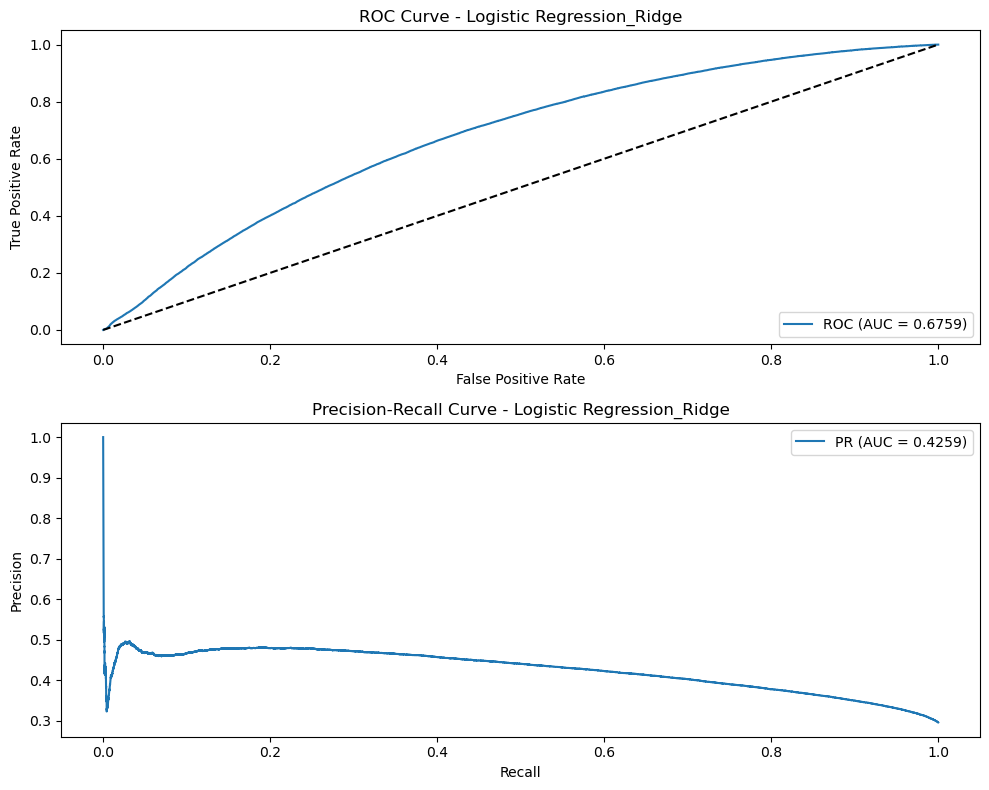

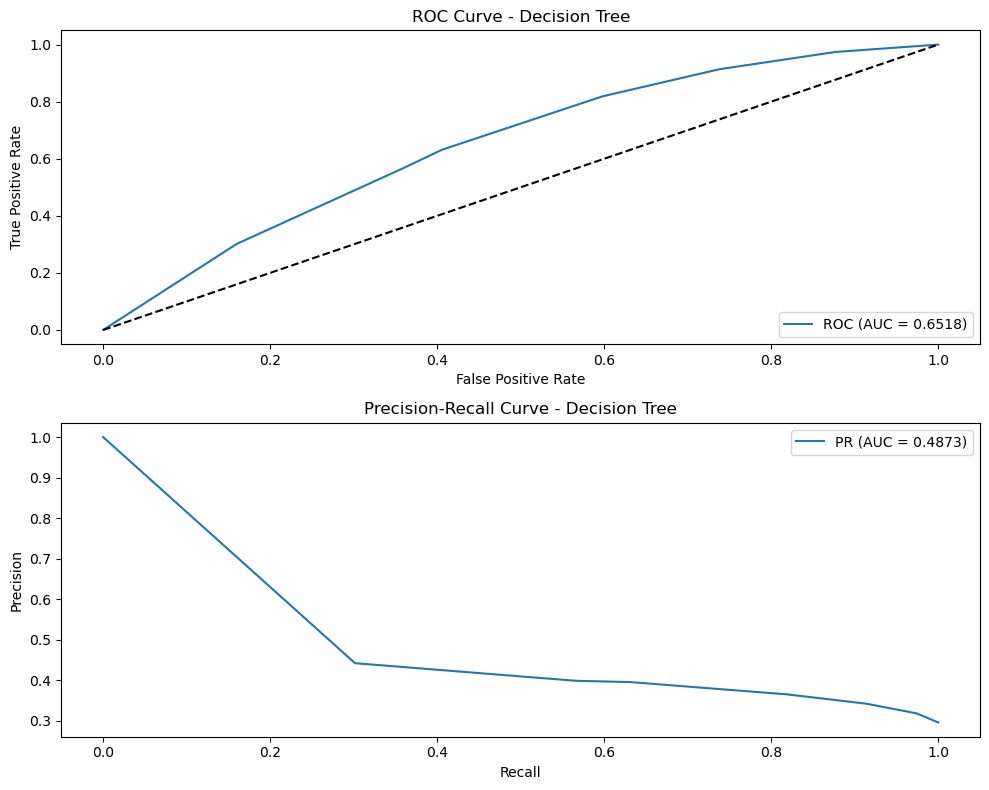

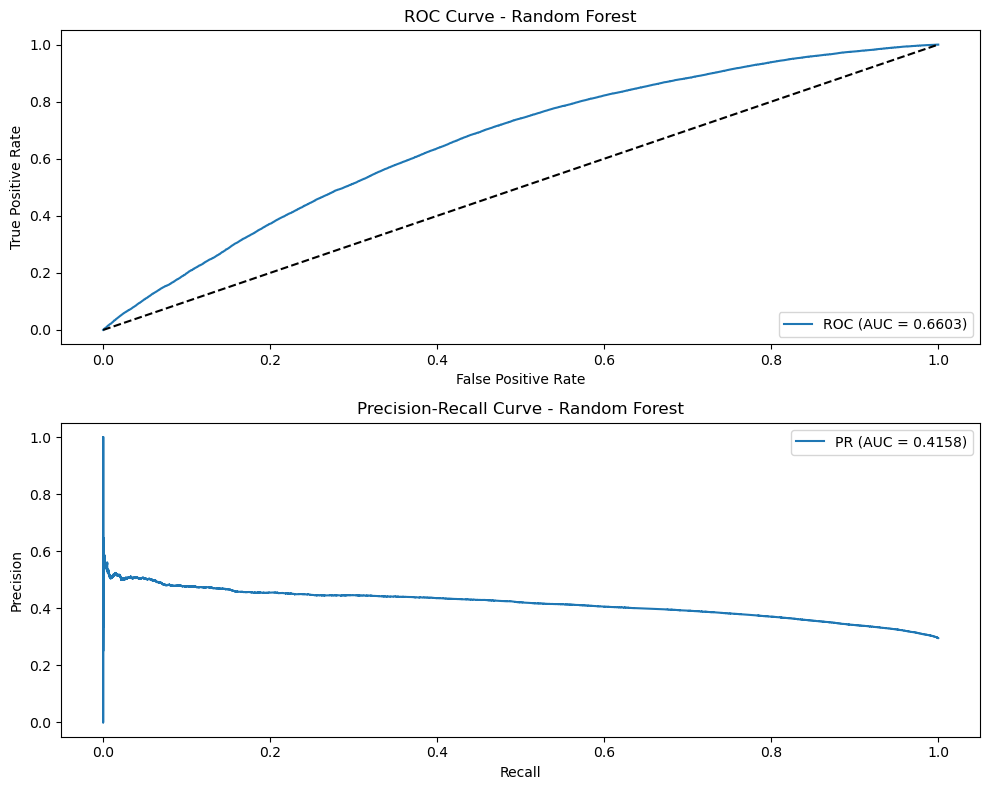

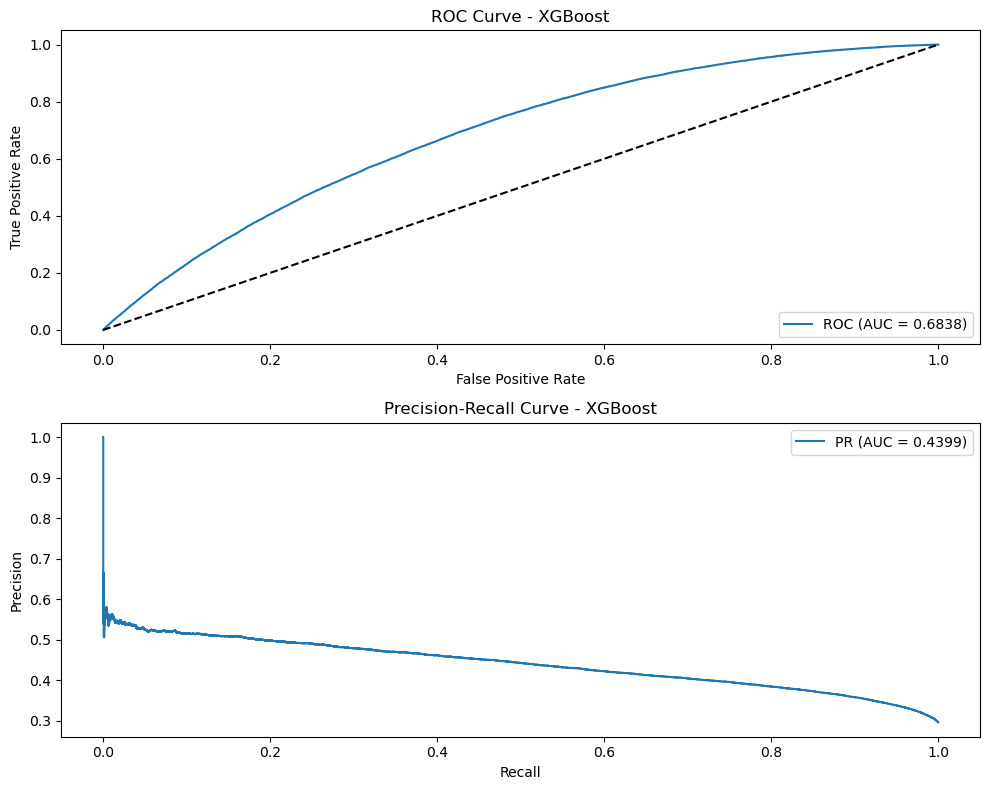

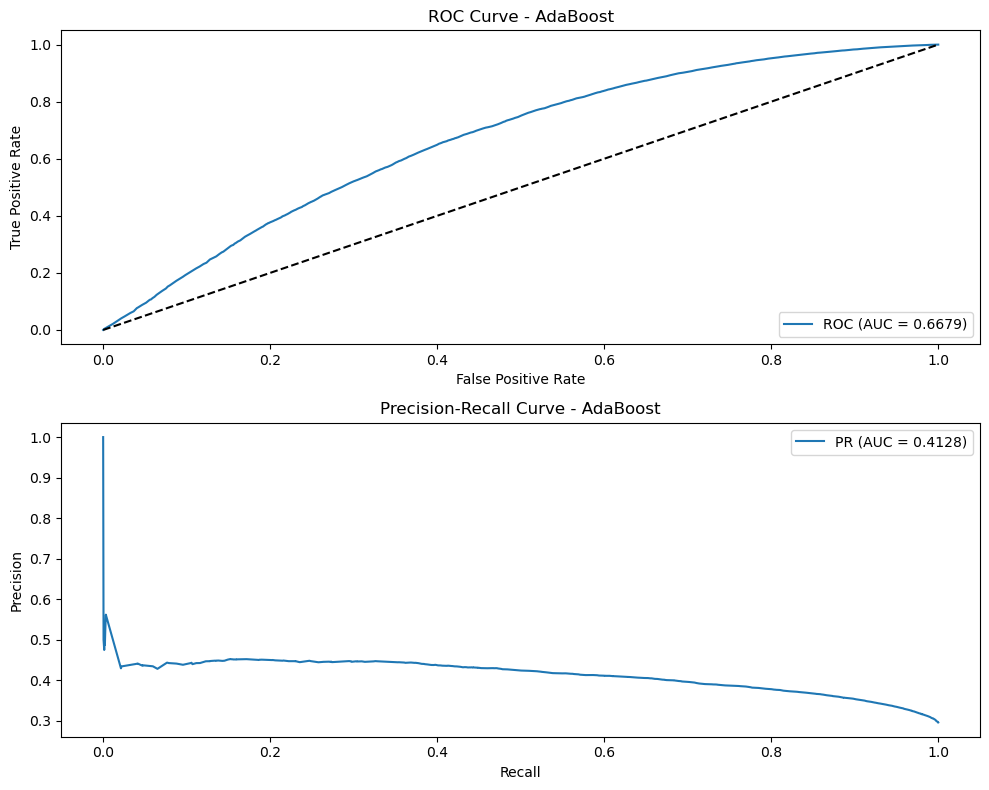

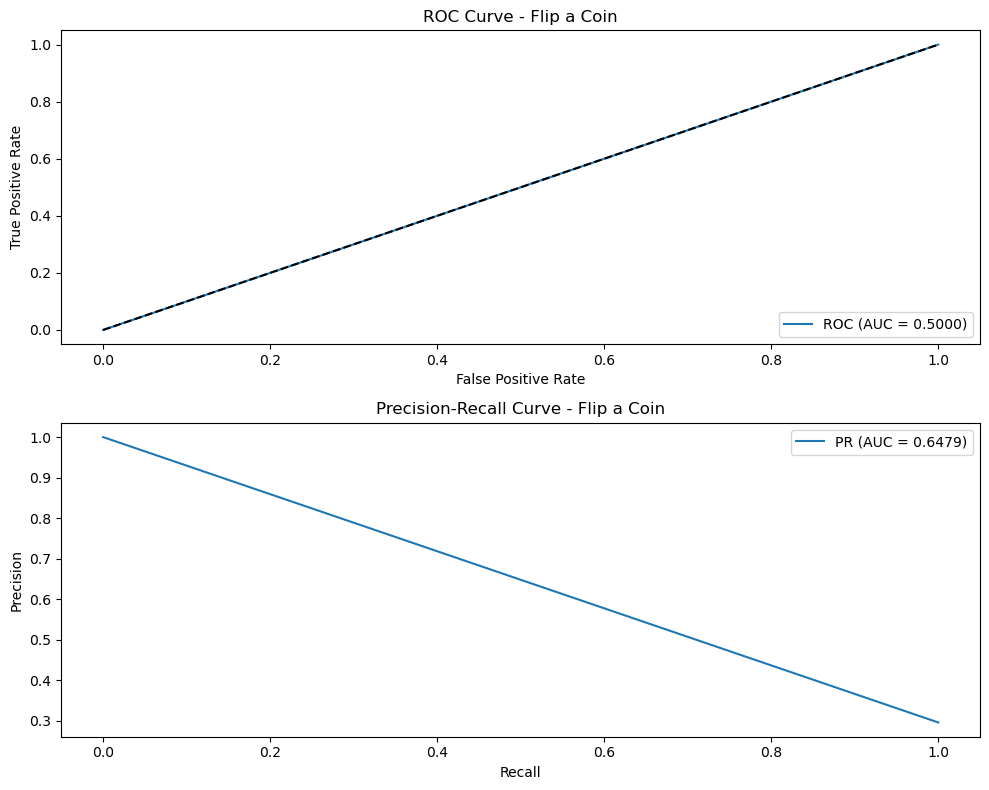

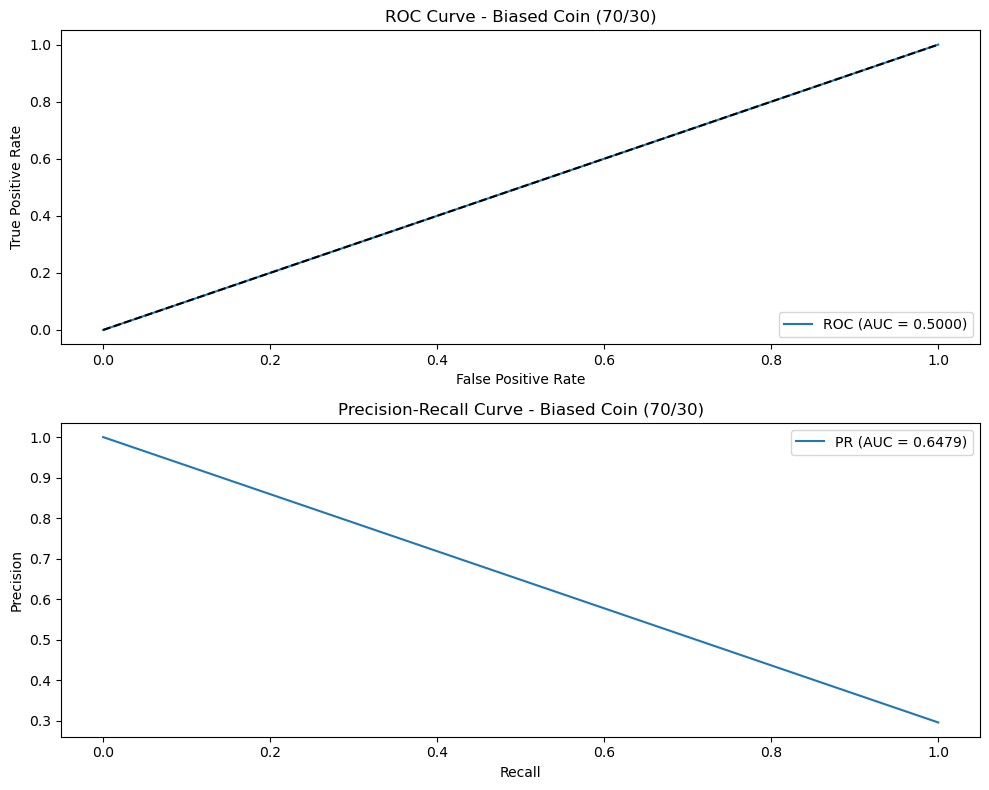

In [82]:
for data in model_curve_data:
    name = data['model_name']
    
    plt.figure(figsize=(10, 8))

    # ROC Curve
    plt.subplot(2, 1, 1)
    plt.plot(data['fpr'], data['tpr'], label=f'ROC (AUC = {data["roc_auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')

    # PR Curve
    plt.subplot(2, 1, 2)
    plt.plot(data['recall'], data['precision'], label=f'PR (AUC = {data["pr_auc"]:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

### Grouped Bar Plot of Main Metrics

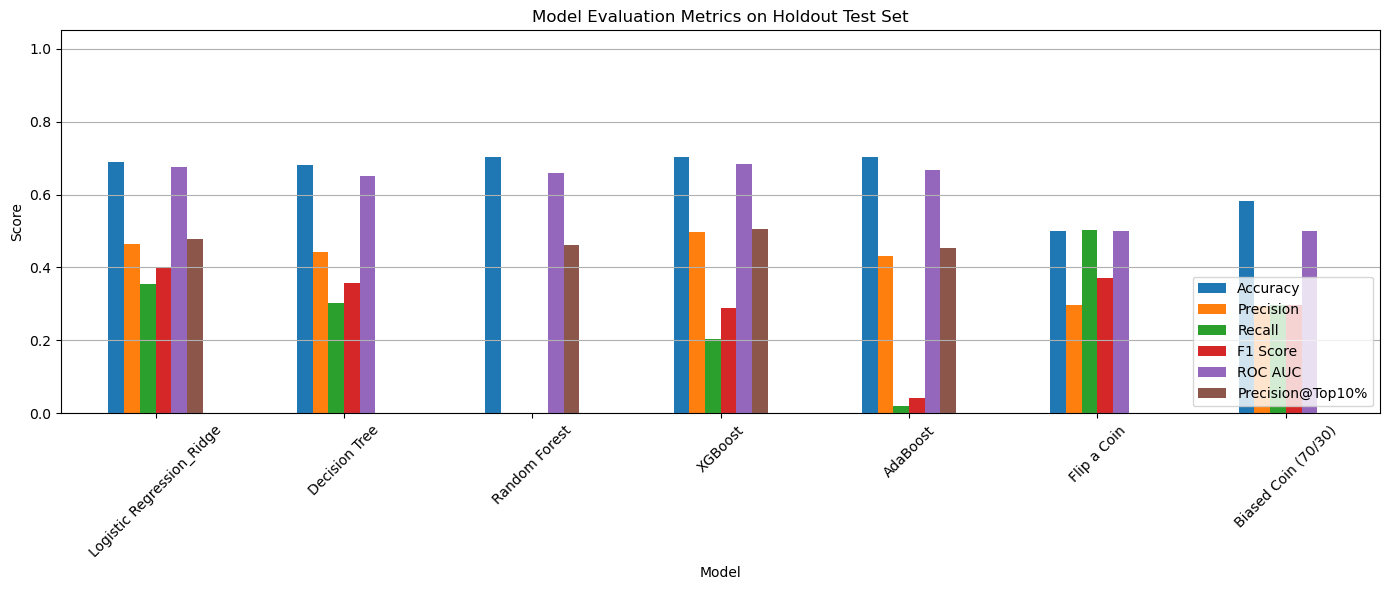

In [85]:
main_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Precision@Top10%']

results_df[main_metrics].plot(kind='bar', figsize=(14, 6), rot=45)
plt.title("Model Evaluation Metrics on Holdout Test Set")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### TP, FP, FN, TN Breakdown

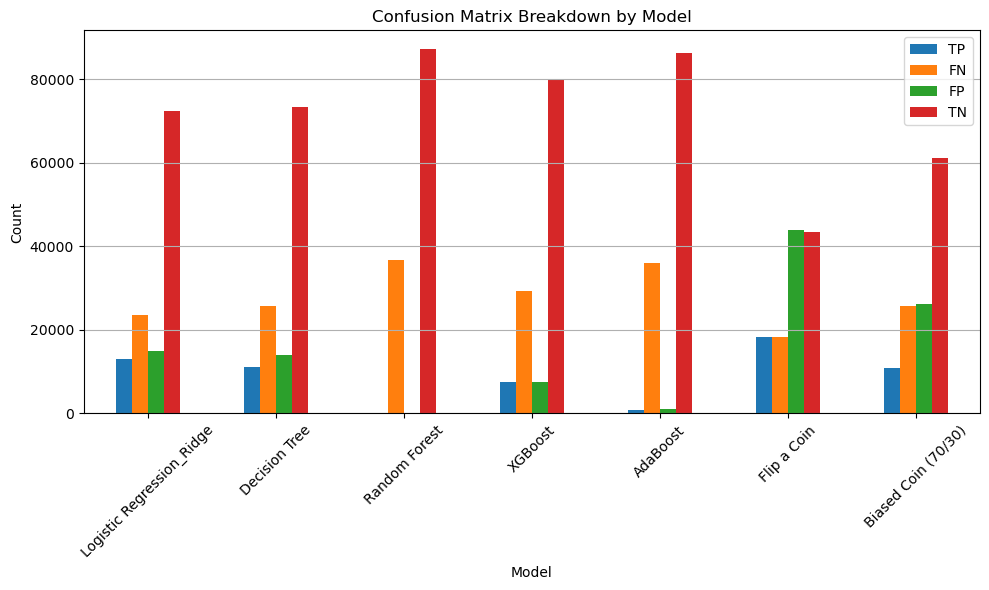

In [88]:
results_df[['TP', 'FN', 'FP', 'TN']].plot(kind='bar', figsize=(10, 6), rot=45)
plt.title("Confusion Matrix Breakdown by Model")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Projects Flagged for Expert Review

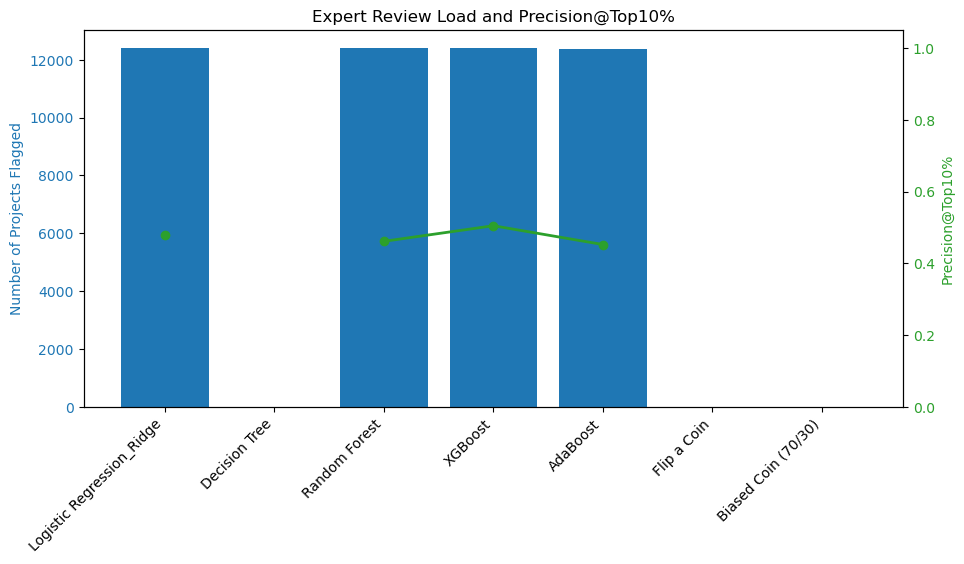

In [91]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
color2 = 'tab:green'

ax1.set_title("Expert Review Load and Precision@Top10%")
ax1.set_ylabel("Number of Projects Flagged", color=color1)
ax1.bar(results_df.index, results_df['num_Projects_flagged_for_review'], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel("Precision@Top10%", color=color2)
ax2.plot(results_df.index, results_df['Precision@Top10%'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 1.05)

# Explicit x-axis label rotation
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

fig.tight_layout(pad=2)
plt.show()

### Heatmap Summary of All Metrics

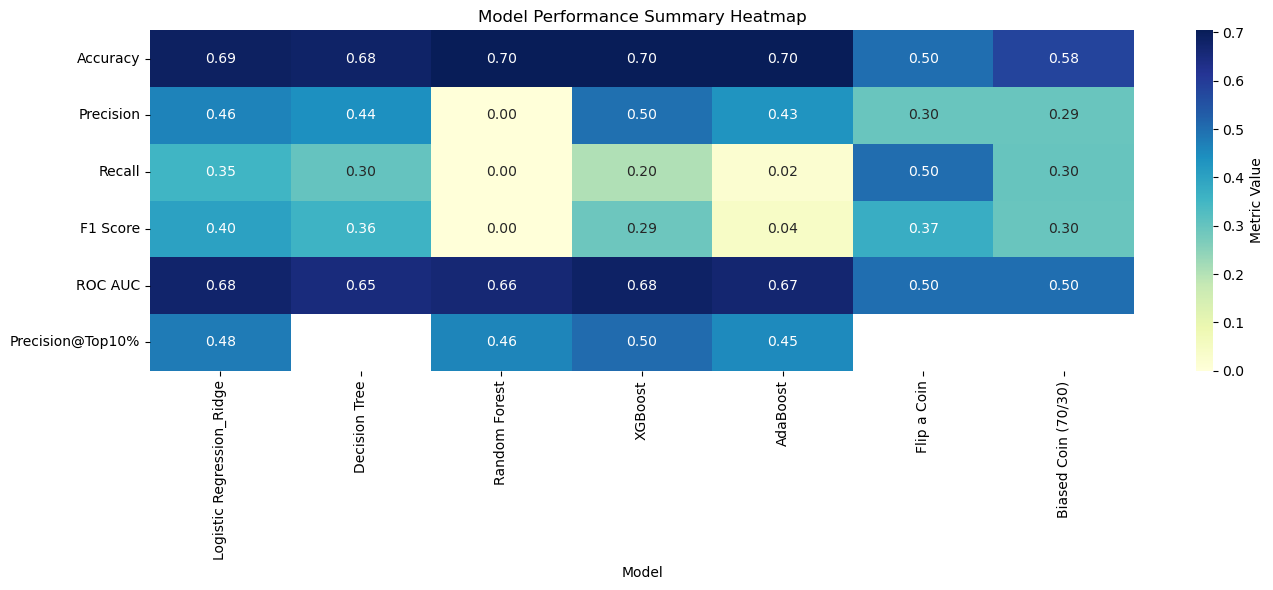

In [94]:
heatmap_metrics = main_metrics # + ['TP', 'FP', 'FN', 'num_Projects_flagged_for_review', 'fraction_Projects_flagged_for_review']

plt.figure(figsize=(14, 6))
sns.heatmap(results_df[heatmap_metrics].T, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Metric Value'})
plt.title("Model Performance Summary Heatmap")
plt.tight_layout()
plt.show()

### Final Metrics Summary Table

In [97]:
pd.set_option("display.precision", 3)

ordered_cols = [
    'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Precision@Top10%',
    'TP', 'FP', 'FN', 'TN',
    'num_Projects_flagged_for_review', 'fraction_Projects_flagged_for_review'
]

# Define highlighting logic
metrics_to_max = [
    'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC',
    'Precision@Top10%', 'TP', 'TN'
]

metrics_to_min = [
    'FP', 'FN'
]

styled = results_df[ordered_cols].style\
    .highlight_max(subset=metrics_to_max, color='lightgreen')\
    .highlight_min(subset=metrics_to_min, color='lightcoral')

display(styled)

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Precision@Top10%,TP,FP,FN,TN,num_Projects_flagged_for_review,fraction_Projects_flagged_for_review
Model,,,,,,,,,,,,
Logistic Regression_Ridge,0.687953,0.464240,0.354699,0.402143,0.675932,0.478117,13021,15027,23689,72334,12407,0.099999
Decision Tree,0.680739,0.442089,0.301634,0.358599,0.651829,nan,11073,13974,25637,73387,0,0.000000
Random Forest,0.704121,0.000000,0.000000,0.000000,0.660296,0.461272,0,0,36710,87361,12407,0.099999
XGBoost,0.703347,0.496809,0.203596,0.288828,0.683801,0.504715,7474,7570,29236,79791,12407,0.099999
AdaBoost,0.702122,0.432682,0.021711,0.041347,0.667902,0.452371,797,1045,35913,86316,12377,0.099757
Flip a Coin,0.499375,0.295891,0.501580,0.372209,0.500000,nan,18413,43816,18297,43545,0,0.000000
Biased Coin (70/30),0.581103,0.294305,0.297439,0.295864,0.500000,nan,10919,26182,25791,61179,0,0.000000
